In [2]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,cross_val_score
import numpy as np
import pandas as pd
from scipy.stats import uniform
import warnings
warnings.filterwarnings("ignore")

### binary classification task

##### dataset: breast cancer dataset from sklearn
##### classifier: random forest

In [3]:
#use the diabetes dataset from sklearn
#binary classification task
x,y=datasets.load_breast_cancer(return_X_y=True)
#Instantiate a RandomForestClassifier
rf=RandomForestClassifier()
baseline=cross_val_score(rf,x,y,scoring='f1').mean()

In [4]:
#use RandomSearchCV to tune the hyperparameters as baseline
#decide the hyperparameter boundaries
param_bounds = {'n_estimators': range(10, 250),
           'min_samples_split': range(2, 25),
           'max_features': uniform(0.1, 0.89),
           'max_depth': range(5, 15)}

In [11]:
rs=RandomizedSearchCV(rf,param_distributions=param_bounds,scoring='f1',n_iter=25)
rs.fit(x,y)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs

In [6]:
bds = [{'name': 'n_estimators', 'type': 'discrete', 'domain': (10, 250)},
        {'name': 'min_samples_split', 'type': 'discrete', 'domain': (2, 25)},
        {'name': 'max_features', 'type': 'continuous', 'domain': (0.1,0.999)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (5, 15)},]

In [7]:
#construct the black box optimization function
def rf_cv(parameters):
    parameters=parameters[0]
    val = cross_val_score(
        # random forest
        RandomForestClassifier(n_estimators=int(parameters[0]),
                               min_samples_split=int(parameters[1]),
                               max_features=min(parameters[2], 0.999),  # float
                               max_depth=int(parameters[3]),
                               random_state=2),
        x, y, scoring='f1',).mean()
    val=np.array(val)
    return val

In [8]:
#Bayesian Optimizer
optimizer = BayesianOptimization(f=rf_cv, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

optimizer.run_optimization(max_iter=20)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

Baseline f1 = 0.96
Random search f1 = 0.96
Bayesian optimization f1 = 0.97


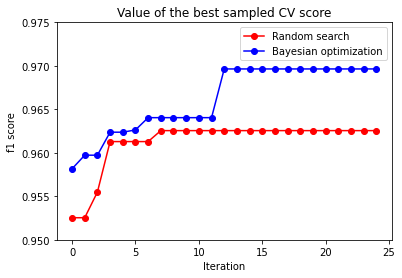

In [14]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline f1 = {baseline:.2f}')
print(f'Random search f1 = {y_rs[-1]:.2f}')
print(f'Bayesian optimization f1 = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('f1 score')
plt.ylim(0.95, 0.975)
plt.title('Value of the best sampled CV score');
plt.legend();

### Try another bayesian optimiaztion library: bayesian_optimization

In [15]:
from bayes_opt import BayesianOptimization

In [16]:
def rf_cv2(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
                               min_samples_split=int(min_samples_split),
                               max_features=min(max_features, 0.999),  # float
                               max_depth=int(max_depth),
                               random_state=2),
        x, y, scoring='f1', cv=5
    ).mean()
    return val

In [17]:
bds2 = {'n_estimators': (10, 250),
           'min_samples_split': (2, 25),
           'max_features': (0.1, 0.999),
           'max_depth': (5, 15)}

optimizer2 = BayesianOptimization(
    f=rf_cv2,  
    pbounds=bds2,  
    verbose=2,  # verbose = 2 prints all
)

In [18]:
optimizer2.maximize(init_points=5,n_iter=20)
#prints the best result and the corresponding hyperparamters
print(optimizer2.max)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9682   |  10.99    |  0.6405   |  11.74    |  74.75    |
|  2        |  0.9653   |  6.187    |  0.4266   |  6.738    |  35.48    |
|  3        |  0.9708   |  10.96    |  0.6833   |  3.376    |  141.9    |
|  4        |  0.9711   |  5.743    |  0.2449   |  2.882    |  57.11    |
|  5        |  0.9667   |  7.347    |  0.4927   |  15.81    |  41.74    |
|  6        |  0.9668   |  5.301    |  0.3454   |  2.803    |  249.2    |
|  7        |  0.9625   |  5.105    |  0.6595   |  24.58    |  151.3    |
|  8        |  0.9676   |  14.96    |  0.6768   |  2.224    |  20.51    |
|  9        |  0.9694   |  14.28    |  0.5045   |  2.069    |  128.8    |
|  10       |  0.9651   |  5.24     |  0.9366   |  2.341    |  106.6    |
|  11       |  0.9695   |  14.88    |  0.6504   |  2.564    |  220.7    |
|  12       |  0.9638   |  14.85    | 

Baseline f1 = 0.96
Random search f1 = 0.96
Bayesian optimization f1 = 0.97


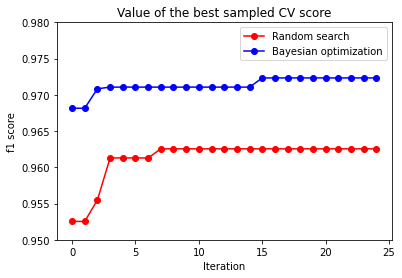

In [19]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo2 = np.maximum.accumulate([i['target'] for i in optimizer2.res]).ravel()

print(f'Baseline f1 = {baseline:.2f}')
print(f'Random search f1 = {y_rs[-1]:.2f}')
print(f'Bayesian optimization f1 = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo2, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('f1 score')
plt.ylim(0.95, 0.98)
plt.title('Value of the best sampled CV score');
plt.legend();

### Regression task

##### dataset: diabetes dataset from sklearn
##### regressor: xgboost 

In [29]:
from xgboost import XGBRegressor

In [30]:
x,y=datasets.load_diabetes(return_X_y=True)
xgb = XGBRegressor()
baseline = cross_val_score(xgb, x, y, scoring='neg_mean_squared_error').mean()

In [44]:
param_bounds = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_bounds, 
                        scoring='neg_mean_squared_error', n_iter=25,random_state=1)

rs.fit(x, y)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monoton...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C581273390>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object

In [45]:
def rf_cv(learning_rate, gamma, max_depth, n_estimators, min_child_weight):
    val = cross_val_score(
        XGBRegressor(learning_rate=learning_rate,
                            gamma=int(gamma),
                            max_depth=int(max_depth),
                            n_estimators=int(n_estimators),
                            min_child_weight=min_child_weight,
                            random_state=1),
        x, y, scoring='neg_mean_squared_error', cv=5
    ).mean()
    return val

bds = {'learning_rate': (0, 1),
           'gamma': (0, 5),
           'max_depth': (1, 50),
           'n_estimators':(1,300),
           'min_child_weight':(1,10)}

optimizer = BayesianOptimization(
    f=rf_cv,  
    pbounds=bds,  
    verbose=2,  # verbose = 2 prints all
)

In [46]:
optimizer.maximize(init_points=5,n_iter=20)
print(optimizer.max)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -4.149e+0 |  0.6839   |  0.1669   |  40.15    |  1.321    |  260.5    |
|  2        | -3.698e+0 |  1.644    |  0.5373   |  1.532    |  6.683    |  293.3    |
|  3        | -4.43e+03 |  0.5555   |  0.5896   |  32.69    |  4.413    |  126.5    |
|  4        | -3.901e+0 |  0.9808   |  0.0159   |  38.55    |  2.273    |  175.9    |
|  5        | -4.478e+0 |  0.07828  |  0.4951   |  46.48    |  1.292    |  24.04    |
|  6        | -3.466e+0 |  1.198    |  0.3661   |  1.616    |  7.482    |  292.5    |
|  7        | -5.406e+0 |  2.74     |  0.9446   |  2.158    |  6.65     |  291.4    |
|  8        | -3.884e+0 |  1.196    |  0.06961  |  38.09    |  2.455    |  174.7    |
|  9        | -5.439e+0 |  0.8415   |  0.8759   |  3.146    |  6.158    |  293.3    |
|  10       | -3.938e+0 |  1.81     |  0.2301   |  35.

Baseline neg. MSE = -3972.59
Random search neg. MSE = -3712.40
Bayesian optimization neg. MSE = -3465.59


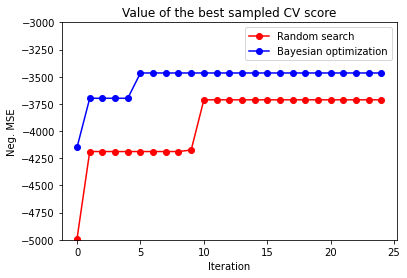

In [47]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate([i['target'] for i in optimizer.res]).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();

### Multi-classification Task

##### dataset: iris dataset from sklearn
##### classifier: svm

In [11]:
from sklearn import svm

In [49]:
x,y=datasets.load_iris(return_X_y=True)
svc = svm.SVC()
baseline = cross_val_score(svc, x, y, scoring='f1_micro').mean()

In [50]:
param_bounds = {"C": uniform(0.01, 0.99),
              "gamma": uniform(0.01, 0.99)}

rs = RandomizedSearchCV(svc, param_distributions=param_bounds, 
                        scoring='f1_micro', n_iter=25,random_state=1)

rs.fit(x, y)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=25, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C581263B38>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C5812B1EB8>},
                   pre_dispatch='2*n_jobs', random_state=1, refit=True,
                   return_train_score=False, scoring='f1_micro', verbose=0)

In [51]:
def svm_cv(C, gamma):
    val = cross_val_score(
        svm.SVC(C=C,
                gamma=gamma),
        x, y, scoring='f1_micro', cv=5
    ).mean()
    return val

bds = {'C': (0.01, 1),
        'gamma': (0.01, 1),}

optimizer = BayesianOptimization(
    f=svm_cv,  
    pbounds=bds,  
    verbose=2,  # verbose = 2 prints all
)

In [52]:
optimizer.maximize(init_points=5,n_iter=20)
print(optimizer.max)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.98     |  0.2546   |  0.6045   |
|  2        |  0.96     |  0.2488   |  0.4739   |
|  3        |  0.98     |  0.8727   |  0.1194   |
|  4        |  0.98     |  0.6776   |  0.5201   |
|  5        |  0.98     |  0.8142   |  0.4841   |
|  6        |  0.9667   |  1.0      |  1.0      |
|  7        |  0.96     |  0.01     |  1.0      |
|  8        |  0.9867   |  0.464    |  1.0      |
|  9        |  0.9333   |  1.0      |  0.01     |
|  10       |  0.9133   |  0.01     |  0.01     |
|  11       |  0.9267   |  0.5316   |  0.01     |
|  12       |  0.9533   |  0.01     |  0.6447   |
|  13       |  0.98     |  1.0      |  0.312    |
|  14       |  0.98     |  0.2871   |  0.8746   |
|  15       |  0.98     |  0.6973   |  0.8869   |
|  16       |  0.98     |  0.7777   |  0.2814   |
|  17       |  0.98     |  0.4676   |  0.7365   |
|  18       |  0.98     |  0.9977   |  0.6951   |


Baseline f1 = 0.97
Random search f1 = 0.98
Bayesian optimization f1 = 0.99


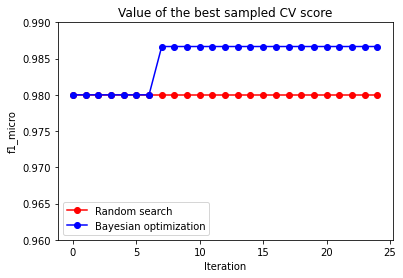

In [53]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate([i['target'] for i in optimizer.res]).ravel()

print(f'Baseline f1 = {baseline:.2f}')
print(f'Random search f1 = {y_rs[-1]:.2f}')
print(f'Bayesian optimization f1 = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('f1_micro')
plt.ylim(0.96, 0.99)
plt.title('Value of the best sampled CV score');
plt.legend();

### Use Bayesian optimization to tune multiple machine learning models on the binary classification task and select the best model

##### dataset: breast cancer dataset from sklearn
##### classifier: random forest, svm, logistic regression classifier

In [3]:
from bayes_opt import BayesianOptimization

In [6]:
x,y=datasets.load_breast_cancer(return_X_y=True)

In [8]:
def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
                               min_samples_split=int(min_samples_split),
                               max_features=min(max_features, 0.999),  # float
                               max_depth=int(max_depth),
                               random_state=2),
        x, y, scoring='f1', cv=5
    ).mean()
    return val
rf_bds = {'n_estimators': (10, 250),
           'min_samples_split': (2, 25),
           'max_features': (0.1, 0.999),
           'max_depth': (5, 15)}

rf_optimizer = BayesianOptimization(
    f=rf_cv,  
    pbounds=rf_bds,  
    verbose=0,
)
rf_optimizer.maximize(init_points=5,n_iter=20)
print(rf_optimizer.max)

{'target': 0.9710090469293966, 'params': {'max_depth': 7.217236054362956, 'max_features': 0.31156749050056054, 'min_samples_split': 2.0822189304690712, 'n_estimators': 249.86020325891238}}


In [14]:
def svm_cv(C, gamma):
    val = cross_val_score(
        svm.SVC(C=C,
                gamma=gamma),
        x, y, scoring='f1', cv=5
    ).mean()
    return val

svm_bds = {'C': (0.01, 1),
        'gamma': (0.01, 1),}

svm_optimizer = BayesianOptimization(
    f=svm_cv,  
    pbounds=svm_bds,  
    verbose=0,
)
svm_optimizer.maximize(init_points=5,n_iter=20)
print(svm_optimizer.max)

{'target': 0.7710648686352012, 'params': {'C': 0.25688361521234426, 'gamma': 0.9767233804174675}}


In [16]:
from sklearn.neighbors import KNeighborsClassifier as knn
def knn_cv(n_neighbors, leaf_size,p):
    val = cross_val_score(
        knn(n_neighbors=int(n_neighbors),
                leaf_size=int(leaf_size),
                p=int(p)),
        x, y, scoring='f1', cv=5
    ).mean()
    return val

knn_bds = {'n_neighbors': (3, 20),
           'leaf_size':(20,100),
           'p': (1, 2),}

knn_optimizer = BayesianOptimization(
    f=knn_cv,  
    pbounds=knn_bds,  
    verbose=0,
)
knn_optimizer.maximize(init_points=5,n_iter=20)
print(knn_optimizer.max)

{'target': 0.9528806896671899, 'params': {'leaf_size': 42.93628708455757, 'n_neighbors': 9.753994913792326, 'p': 1.9906675662330198}}


In [18]:
from sklearn.linear_model import LogisticRegression as lr
def lr_cv(C):
    val = cross_val_score(
        lr(C=C),
        x, y, scoring='f1', cv=5
    ).mean()
    return val

lr_bds = {'C': (0.01, 1)}

lr_optimizer = BayesianOptimization(
    f=lr_cv,  
    pbounds=lr_bds,  
    verbose=0,
)
lr_optimizer.maximize(init_points=5,n_iter=20)
print(lr_optimizer.max)

{'target': 0.9628438731619404, 'params': {'C': 0.9834668290359118}}
